In [1]:
import re
import os
import time
import numpy as np
import pandas as pd
import scipy.stats as stats
from random import randint
from matplotlib.ticker import MaxNLocator
from functools import partial
import pickle

from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline

from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import sparse

import nltk
from nltk.stem import PorterStemmer 
from nltk.tokenize import sent_tokenize, word_tokenize

import utils.data_lake_helper as dl_helper

In [2]:
data_lake = dl_helper.DataLake(version='v3')

In [3]:

def load_feature(feature):
    df_[feature] = data_lake.load_obj(feature + '.pkl')

In [4]:
df_train_table = pd.read_csv('../source/dataset/train_set.csv')
df_train_table.index = df_train_table.pk_id
del df_train_table['pk_id']

df_test_table = pd.read_csv('../source/dataset/test_set.csv')
df_test_table.index = df_test_table.pk_id
del df_test_table['pk_id']

df = df_train_table.append(df_test_table, sort=False)

In [5]:
print(df.head())
print()
print(df.describe())

         category file_type master_tree
pk_id                                  
7458273        RL       htm     CORRESP
17561810       UU       htm     CORRESP
7859969        RL       htm     CORRESP
13471870       AR       htm     CORRESP
7847948        AR       htm     CORRESP

       category file_type master_tree
count     55556     55556       55556
unique       11         3           2
top          RL       htm     CORRESP
freq      21246     25911       29012


### Categories distribution

Dataframe with the type of category, the number of cards for each category,
the percentage they represent of the total number of cards.

- X axis: category
- Y axis: percentage that represents the category (0% to 100%)

In [6]:
df_ = round(df.groupby('category').category.count() / len(df) * 100, 2)
df_ = pd.DataFrame(df_)
df_.columns = ['percentage']
df_['count'] = df.groupby('category').category.count()

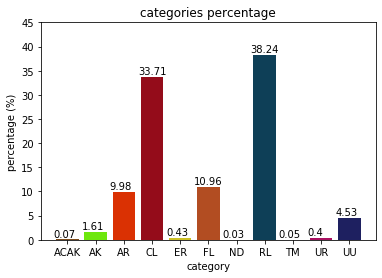

In [23]:
y = df_.percentage
x = df_.index

colors = []
for i in range(len(x)):
    colors.append('#%06X' % randint(0, 0xFFFFFF))
    
plt.bar(x, y, color=colors)    
plt.xlabel('category')
plt.ylabel('percentage (%)')
plt.title('categories percentage')

xlocs, xlabs = plt.xticks()
for i, v in enumerate(y):
    plt.text(xlocs[i] - 0.5, v + 0.5, str(v))
    
axes = plt.gca()
axes.set_ylim([0,45])

plt.show()

#### Here we can see an unbalanced data set, probably the smallest categories will not have good metrics, it should be evaluated if any strategy is necessary to solve this problem. Some options are:
- remove items from greatter categories
- data augmentation from smaller categories

### Letter length distribution

data frame containing the id and length of the doc in characters.

Chart of the distribution of the cards,
- X axis: the number of characters grouped by range.
- Y axis: the number of cards that correspond to a rank.

In [8]:
df_train_table_ = df_train_table.copy()
df_train_table_['path'] = '../source/dataset/train_set/'

df_test_table_ = df_test_table.copy()
df_test_table_['path'] = '../source/dataset/test_set/'

df_ = df_train_table_.append(df_test_table_, sort=False)

del df_['master_tree']

In [9]:
load_feature('letter_lenght')

load_feature('word_count')

load_feature('word_density')

Text(0.5, 1.0, 'letter_lenght distribution')

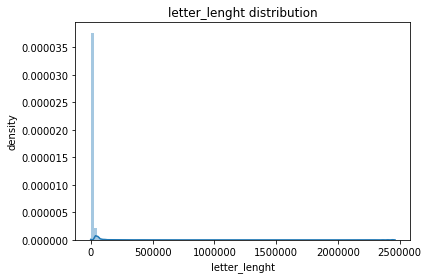

In [28]:
sns.distplot(df_.letter_lenght, bins = 100)
plt.ylabel('density')
plt.title('letter_lenght distribution')

Text(0.5, 1.0, 'letter_lenght distribution')

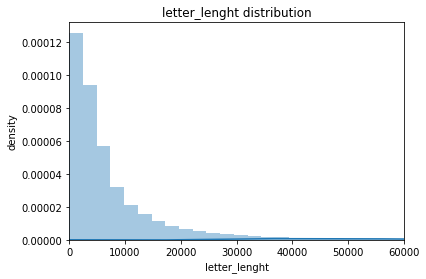

In [29]:
sns.distplot(df_.letter_lenght, bins = 1000)
plt.xlim(0, 60000)
plt.ylabel('density')
plt.title('letter_lenght distribution')

In [30]:
threshold = 40000
msg = "df_.letter_lenght > " + str(threshold) + " =>"
print(msg, round(len(df_[df_.letter_lenght > threshold]) / len(df_) * 100, 2))
print(msg, df_[df_.letter_lenght > threshold].category.unique())

df_.letter_lenght > 40000 => 3.18
df_.letter_lenght > 40000 => ['RL' 'CL' 'UU']


#### features vs categories

The dataframe and its intrinsic features are already available.

graph of how each intrinsic feature is distributed by each category.
The intrinsics features are:
- extension type (categorical)
- card length (numeric)

===

in case of letters length:
- X axis: the number of characters grouped by rank by category.
- Y axis: the number of cards that correspond to a rank.
(there will be a graph for each category, they may be superimposed)


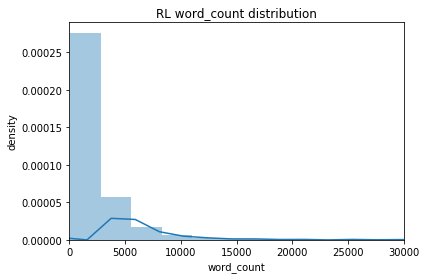

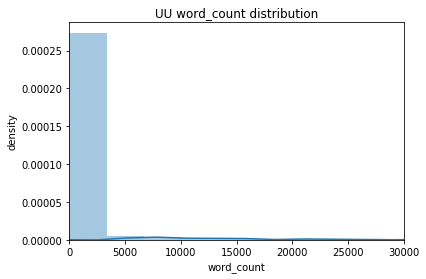

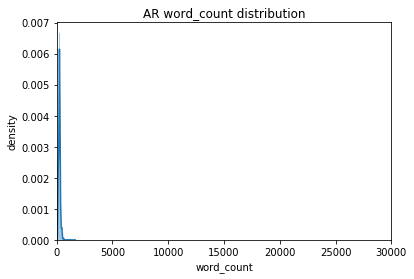

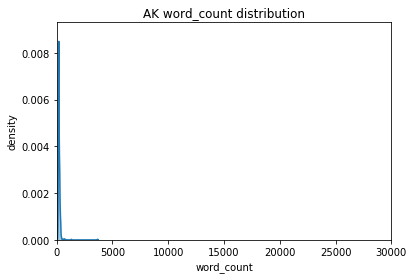

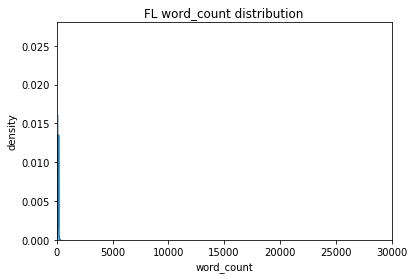

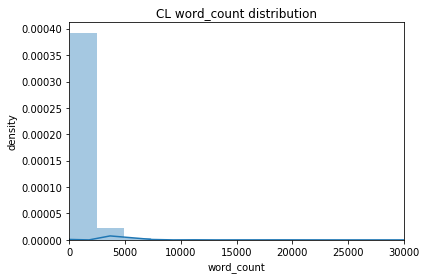

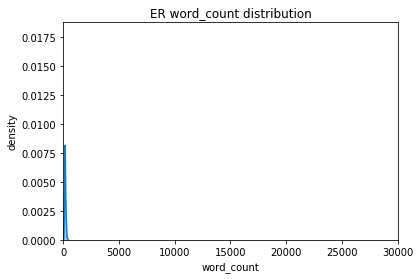

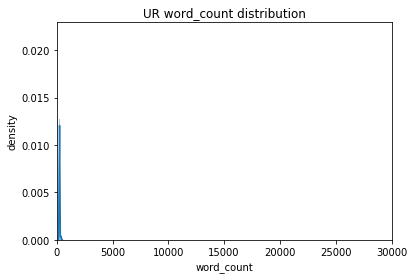

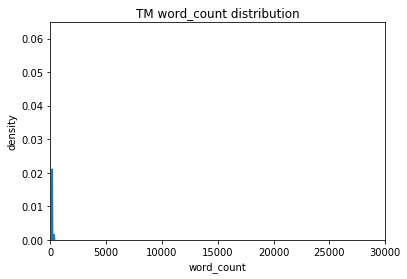

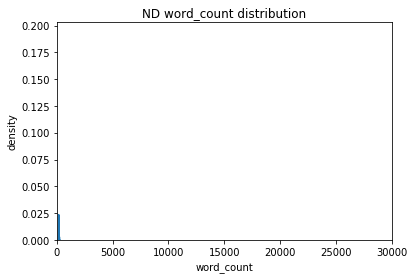

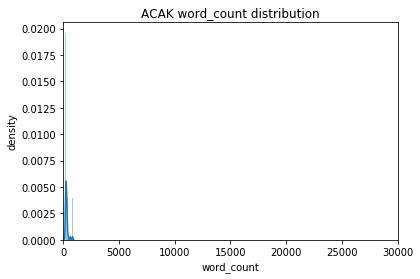

In [32]:
for i, category in enumerate(df_.category.unique()):
    _ = plt.figure(i)
    
    df_category = df_[df_.category == category]
    sns.distplot(df_category.word_count, bins = 100)
    plt.xlim(0, 30000)#df_category.letter_lenght.max())
    plt.ylabel('density')
    plt.title(category + ' word_count distribution')
    
plt.show()

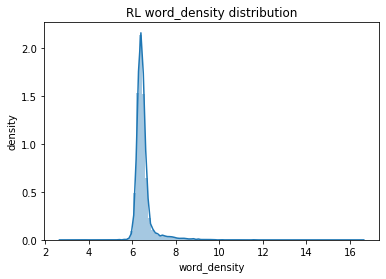

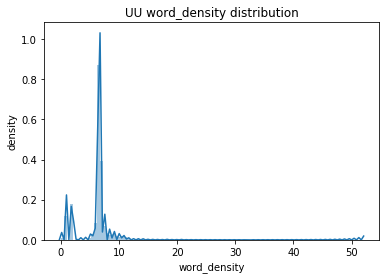

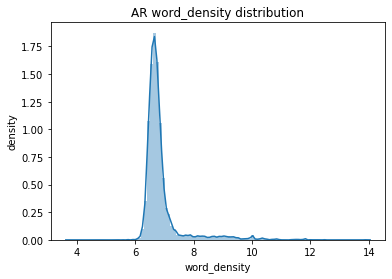

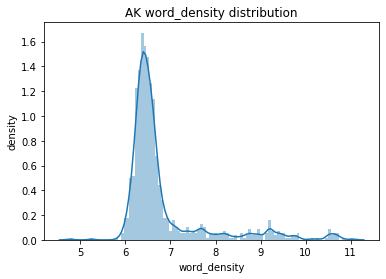

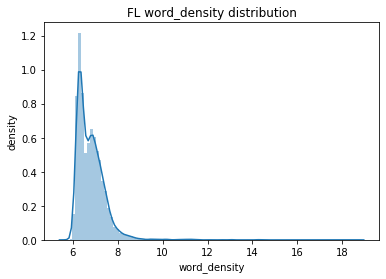

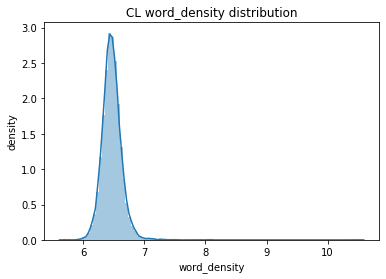

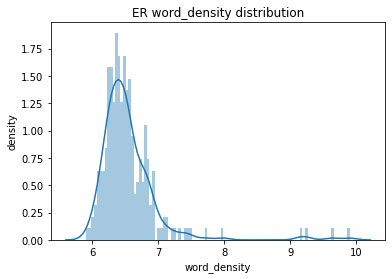

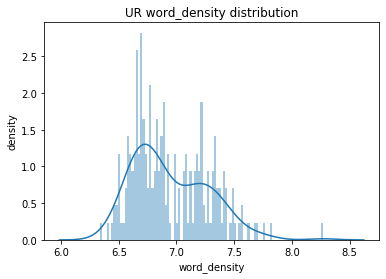

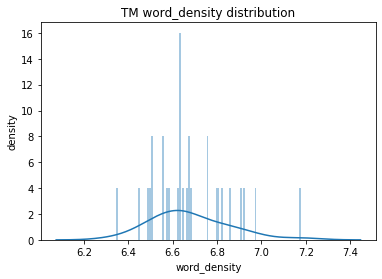

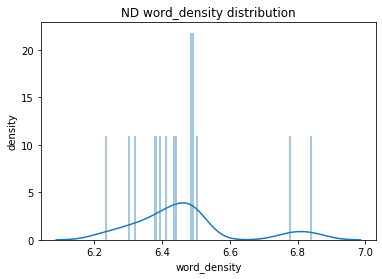

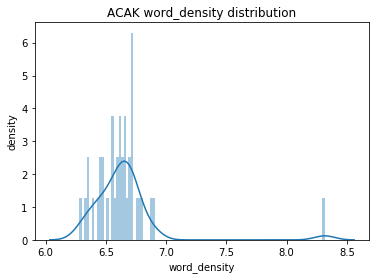

In [33]:
for i, category in enumerate(df_.category.unique()):
    _ = plt.figure(i)
    
    df_category = df_[df_.category == category]
    sns.distplot(df_category.word_density, bins = 100)
    #plt.xlim(0, 30000)#df_category.letter_lenght.max())
    plt.ylabel('density')
    plt.title(category + ' word_density distribution')
    
plt.show()

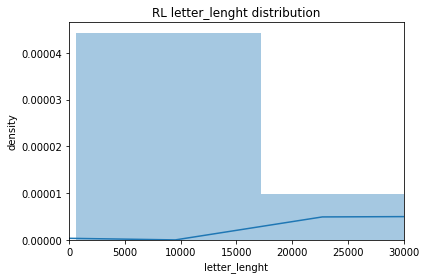

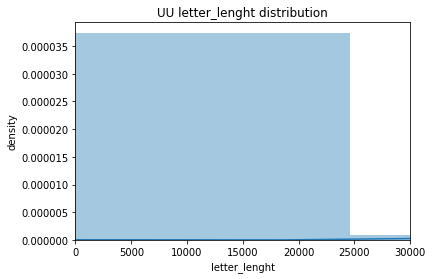

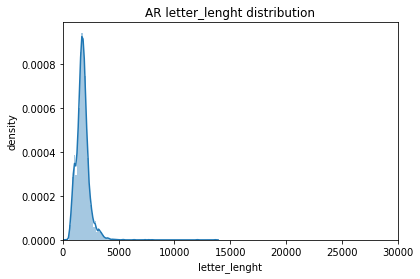

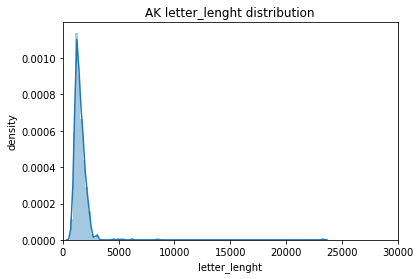

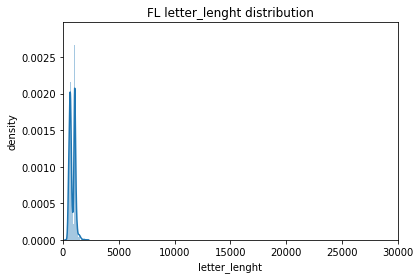

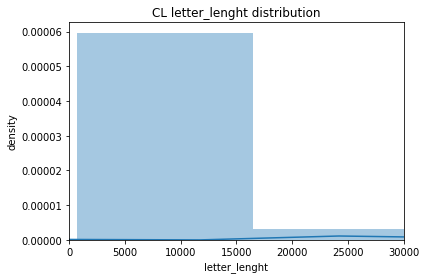

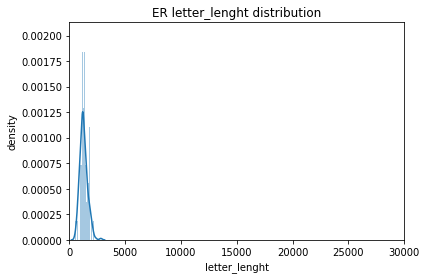

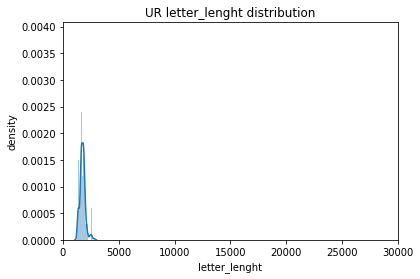

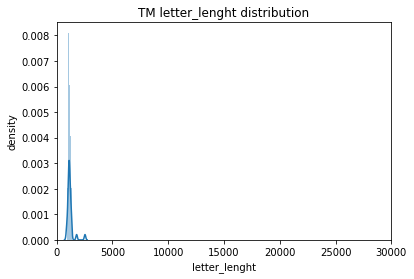

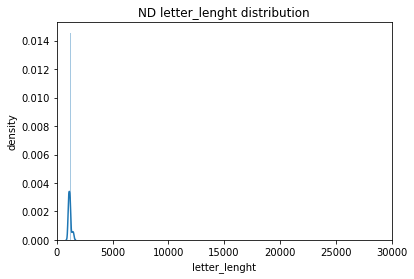

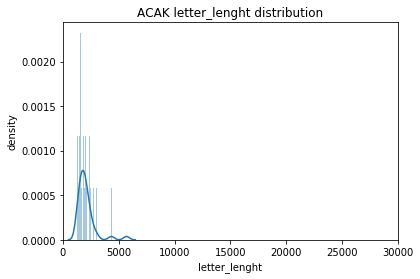

In [34]:
for i, category in enumerate(df_.category.unique()):
    _ = plt.figure(i)
    
    df_category = df_[df_.category == category]
    sns.distplot(df_category.letter_lenght, bins = 100)
    plt.xlim(0, 30000)#df_category.letter_lenght.max())
    plt.ylabel('density')
    plt.title(category + ' letter_lenght distribution')
    
plt.show()

if letter length> 5000, then can only be RL, CL, UU and ACAK (although ACAK is much less likely)

In [35]:
"""df_category = df_[df_.category == 'RL']
sns.distplot(df_category.letter_lenght, bins = 500)
plt.xlim(0, 100000)
plt.ylabel('density')
plt.title('letter_lenght distribution')

df_category = df_[df_.category == 'CL']
sns.distplot(df_category.letter_lenght, bins = 500)
plt.xlim(0, 100000)
plt.ylabel('density')
plt.title('letter_lenght distribution')"""

"df_category = df_[df_.category == 'RL']\nsns.distplot(df_category.letter_lenght, bins = 500)\nplt.xlim(0, 100000)\nplt.ylabel('density')\nplt.title('letter_lenght distribution')\n\ndf_category = df_[df_.category == 'CL']\nsns.distplot(df_category.letter_lenght, bins = 500)\nplt.xlim(0, 100000)\nplt.ylabel('density')\nplt.title('letter_lenght distribution')"

I leave as an example the code to see how 2 distributions overlap

#### Graph of how each intrinsic feature is distributed by each category.

The dataframe and its intrinsic features are already available.

The intrinsics features are:
- extension type (categorical)
- card length (numeric)

===

in case of extension type:
- X axis: categories (CL, RL, etc) grouped by extension types (html, pdf, txt)
- Y axis: the number of cards that correspond to the X axis (that is, that corresponds for such extension type of such category)

In [37]:
df_cat_dummy = pd.DataFrame()
df_cat_dummy['file_type'] = np.zeros(len(df_.category.unique()))
df_cat_dummy.index = df_.category.unique()
df_cat_dummy

colors = []
for i in range(len(df_.category.unique())):
    colors.append('#%06X' % randint(0, 0xFFFFFF))

In [38]:
def graph(filter_key, group_key, sort_key_value='category', 
          ylim_value=None, use_dummy_df=True, graph_colors=None,
          xlabel_value='', ylabel_value='', show_bar_values=False, maxnlocator=None):
    
    global colors
    
    for i, filter_key_value in enumerate(df_[filter_key].unique()):
        _ = plt.figure(i)

        df_filtered = df_[df_[filter_key] == filter_key_value]
        df_grouped = df_filtered.groupby(group_key).count()

        if use_dummy_df:
            #agrego categories que no estan 
            for i in range(0, len(df_cat_dummy)):
                item = df_cat_dummy.iloc[i]
                if item.name not in df_grouped.index:
                    df_grouped = df_grouped.append(item)

        df_grouped.sort_values(by=[sort_key_value], inplace=True)

        y = df_grouped.file_type
        x = df_grouped.index
        
        if ylim_value is not None:
            plt.ylim(0, ylim_value)

        if maxnlocator is not None:
            ax = plt.figure().gca()
            ax.xaxis.set_major_locator(MaxNLocator(integer=maxnlocator))

        colors_list = []
        if graph_colors is None:
            colors_list = colors
        else:
            colors_list = graph_colors
        
        plt.bar(x, y, color=colors_list, tick_label=x)    
        plt.xlabel(xlabel_value)
        plt.ylabel(ylabel_value)
        plt.title(filter_key_value)
        
        if show_bar_values:
            total = df_grouped.file_type.sum()
            df_grouped['percentage'] = round(df_grouped.file_type / total * 100, 2)
            
            xlocs, xlabs = plt.xticks()
            for i, v in enumerate(y):
                y_value = df_grouped.percentage.iloc[i]
                plt.text(xlocs[i] - 0.5, v + 100, str(y_value)+'%')

    plt.show()

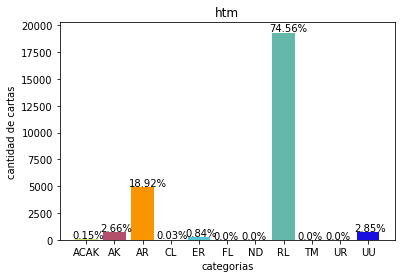

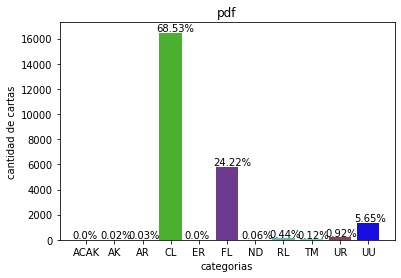

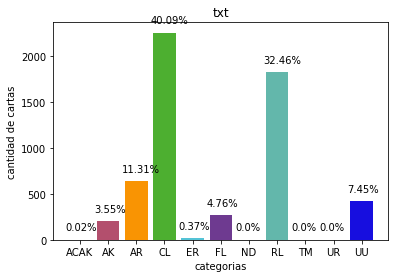

In [39]:
graph(filter_key='file_type', group_key='category', 
      show_bar_values=True,
      xlabel_value='categorias', ylabel_value='cantidad de cartas')

if it is htm or pdf there is a high probability that it is RL or CL respectively

#### presence of enums per category

data frame with category, total cards per category, number of cards with numbered.

- X axis: categories grouped by presence of enum (true or false)
- Y axis: number of letters that are listed

In [41]:
load_feature('enumeration_presence')

load_feature('enumeration_count')

load_feature('enumeration_repeated')

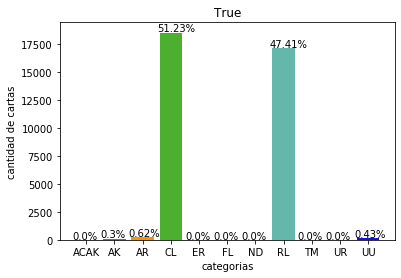

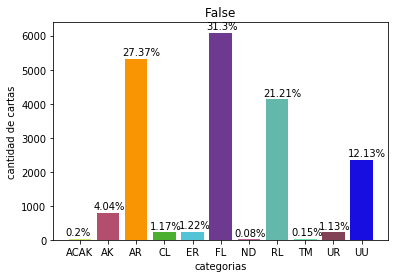

In [42]:
graph(filter_key='enumeration_presence', group_key='category', 
      xlabel_value='categorias', ylabel_value='cantidad de cartas', show_bar_values=True)

if you have it listed it is very likely to be a letter type RL or CL

#### number of enums per category

- X axis: number of enumerated found in a letter
- Y axis: number of cards in category X that have such number of numbered

<Figure size 432x288 with 0 Axes>

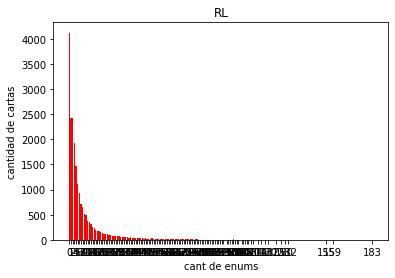

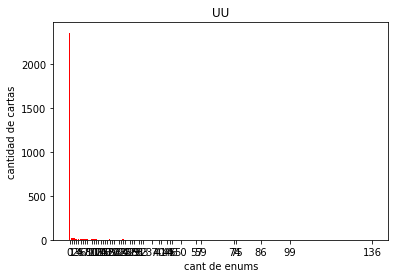

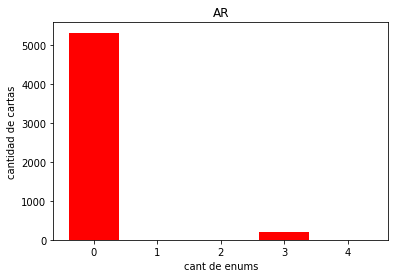

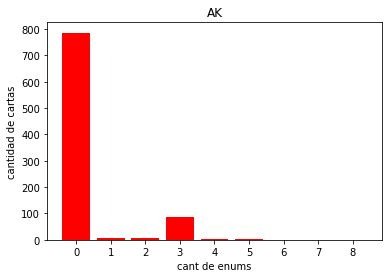

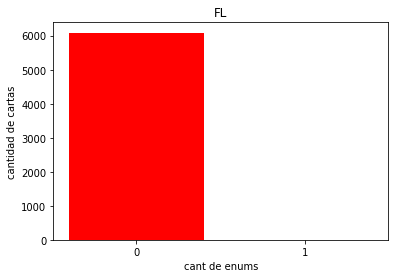

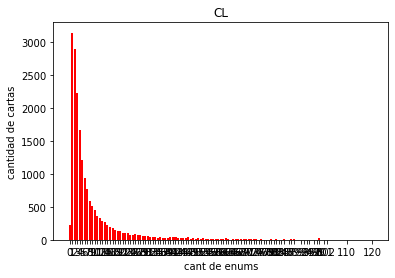

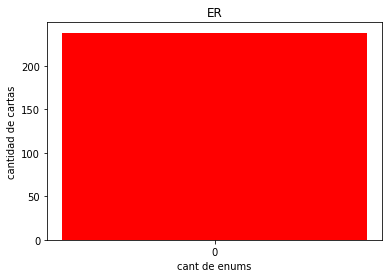

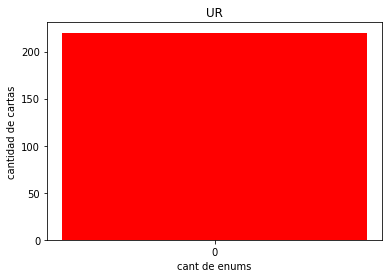

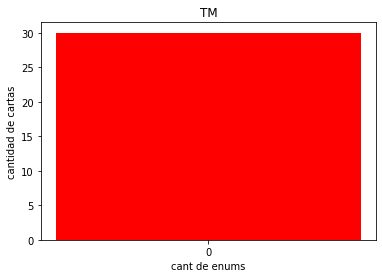

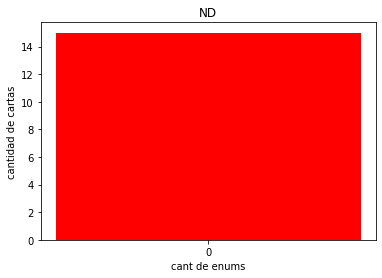

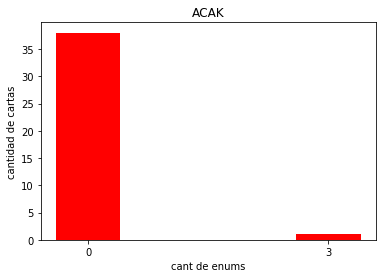

In [44]:
graph(filter_key='category', group_key='enumeration_count', sort_key_value='enumeration_count',
      maxnlocator = True, use_dummy_df=False, graph_colors=['red'],
      xlabel_value='cant de enums', ylabel_value='cantidad de cartas')

#### number of duplicate enums per category

- X axis: categories
- Y axis: number of cards in category X that have repeated enumerations

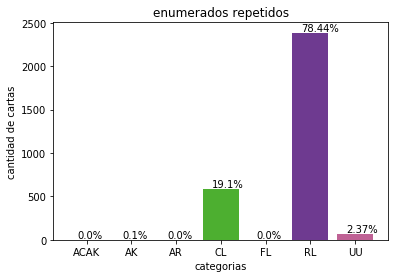

In [46]:
df_filtered = df_[df_.enumeration_presence == True]

dummy_cat_list = df_filtered.category.unique()

df_filtered = df_[df_.enumeration_repeated == True]

df_grouped = df_filtered.groupby('category').count()

#agrego categories que no estan y cumplen con -> enumeration_presence == True 
for i in range(0, len(dummy_cat_list)):
    dummy_cat = dummy_cat_list[i]
    if dummy_cat not in df_grouped.index:
        dummy_df = pd.DataFrame()
        dummy_df['category'] = [dummy_cat]
        dummy_df['file_type'] = [0]
        dummy_df.index = dummy_df.category
        del dummy_df['category']
        df_grouped = df_grouped.append(dummy_df, sort=True)

df_grouped.sort_values(by=['category'], inplace=True)

y = df_grouped.file_type
x = df_grouped.index
#plt.ylim(0, 10)

plt.bar(x, y, color=colors)    
plt.xlabel('categorias')
plt.ylabel('cantidad de cartas')
plt.title('enumerados repetidos')

total = df_grouped.file_type.sum()
df_grouped['percentage'] = round(df_grouped.file_type / total * 100, 2)
    
xlocs, xlabs = plt.xticks()
for i, v in enumerate(y):
    y_value = df_grouped.percentage.iloc[i]
    plt.text(xlocs[i] - 0.2, v + 20, str(y_value)+'%')

if it has the enumeration repeated there are high probabilities that it is RL or CL

#### presence of SEC header per category

data frame with id, category type, presence of SEC header
- X axis: categories grouped by presence of enum (true or false)
- Y axis: number of letters that present enumeration

In [49]:
#SEC letters classification
################################

load_feature('sec_header_presence')

<Figure size 432x288 with 0 Axes>

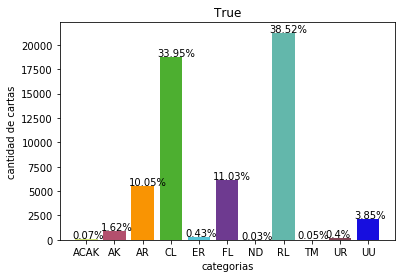

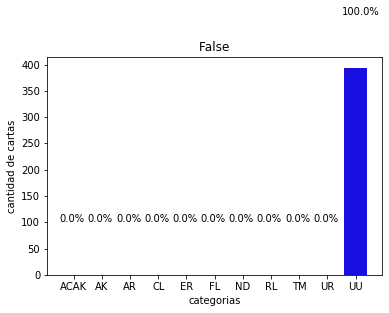

In [50]:
graph(filter_key='sec_header_presence', group_key='category', sort_key_value='category',
      maxnlocator = False, use_dummy_df=True, show_bar_values=True,
      xlabel_value='categorias', ylabel_value='cantidad de cartas')

#### data frame with id, category type, pattern presence

a graph will be made for each pattern
- X axis: categories grouped by presence of pattern (true or false)
- Y axis: number of cards that have the pattern


In [52]:
#Response letters classification
################################

load_feature('response_presence')

<Figure size 432x288 with 0 Axes>

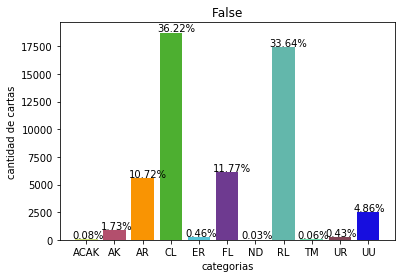

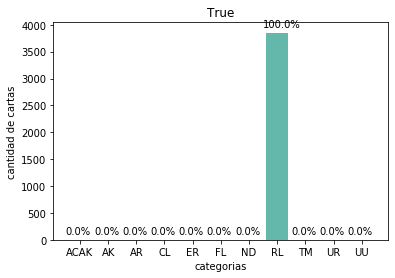

In [53]:
graph(filter_key='response_presence', group_key='category', sort_key_value='category',
      maxnlocator = False, use_dummy_df=True, show_bar_values=True,
      xlabel_value='categorias', ylabel_value='cantidad de cartas')

In [54]:
#Comment letters classification
################################

load_feature('cl_sentence_presence')

<Figure size 432x288 with 0 Axes>

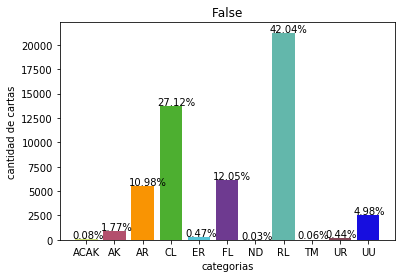

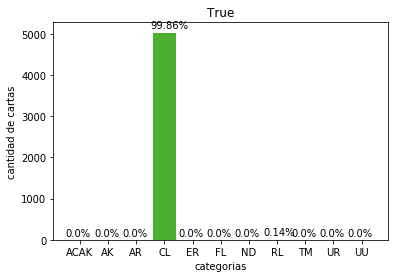

In [55]:
graph(filter_key='cl_sentence_presence', group_key='category', sort_key_value='category',
      maxnlocator = False, use_dummy_df=True, show_bar_values=True,
      xlabel_value='categorias', ylabel_value='cantidad de cartas')

## t-SNE

In [3]:
import numpy as np
from sklearn.manifold import TSNE
from numpy import save as numpy_save
from numpy import load as numpy_load
from keras import preprocessing
import seaborn as sns

In [ ]:
# word level tf-idf
xtrain_tfidf = data_lake.load_npz("xtrain_tfidf.npz")

# label encode the target variable 
train_y = df_train_table.category
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)


In [44]:
try:
    xtrain_tfidf_tsne = numpy_load('xtrain_tfidf_tsne.npy')
except:
    xtrain_tfidf_tsne = TSNE(n_components=2).fit_transform(xtrain_tfidf)
    numpy_save('xtrain_tfidf_tsne.npy', xtrain_tfidf_tsne)


<AxesSubplot:>

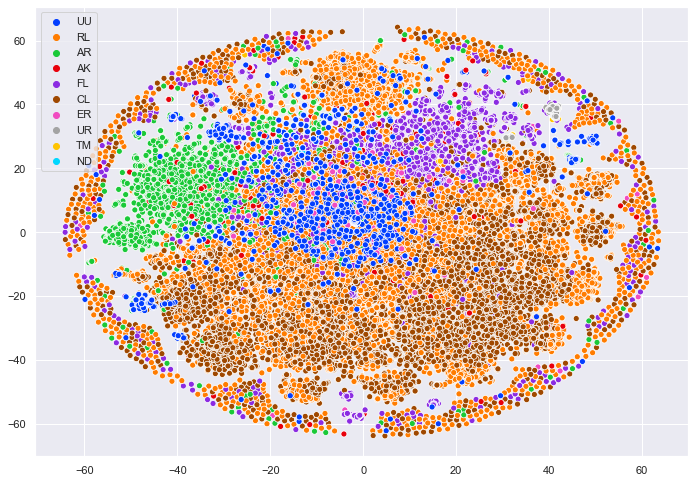

In [95]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)

valores = [k for (k,v) in zip(df_train_table.category, train_y)]
sns.scatterplot(xtrain_tfidf_tsne[:,0], xtrain_tfidf_tsne[:,1], hue=valores, legend='full', palette=palette)


Although the algorithm had to reduce many dimensions, based on the graph, we can see that categories UU, RL, AR, FL CL have the majority of their points grouped and we can identify them with some ease, while the rest of the categories are difficult to visualize. Therefore we can expect better metrics for the first mentioned categories

##### Observations 
- After exploring the dataset we did not find relevant insights to inform to the client, although we managed to obtain some features that we will use to create a baseline model, and also use them in prediction tasks.